# Overview
Projects often need human collaboration to reach their full potential. At the time of this creation, we have run this project with two datasets and achieved dramatically different results. The main difference being the quality of the dataset labels. In our first run we used the images scraped from the Race Identification project for the no mask group, and added in only 100 or so images to represent the mask wearing group. This model scored an accuracy of roughly 80% on unseen data. In our current model, we have nearly 2000 images split evenly, and at times can only predict at 50% accuracy. This means after all of the effort put in, our model is essentially just flipping a coing on every image. So, to get the most out of this larger dataset, we make sure the label are of the highest quality.

The process seen below is similar to that of an Amazon Turk, where we have to manually go though a label each image. Rather than over riding the image labels, we will save this updated label separately, as a new feature, for further analysis moving forward. 

# Imports

In [1]:
from IPython.display import clear_output

import pickle
from PIL import Image 
import pandas as pd
import pymongo
import numpy as np
import json
import time

# Connecting to MongoDB

In [2]:
user = ""
pswd = ""

In [3]:
client = pymongo.MongoClient("mongodb+srv://{}:{}@cluster0.x6cn9.mongodb.net/DATA_603?retryWrites=true&w=majority".format(user, pswd))
db = client["DATA_603"]
# collection = db["images"]

# Manually Labeling Data
By running the script below, you will have the opportunity to run through each image in the database and label, or delete accordingly. Your progress will be saved after each run, although it is encouraged that you finish a DB Collection prior to ending so that you don't have to relabel images. This saved state can be found in Human_Collaboration_Last_Saved.txt. Additionally, please use the enter key to escape safely and ensure your progress is saved.

Collection 31 out of 54
Index 6 out of 38


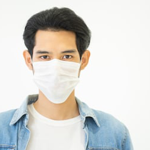

Please enter one of the following:
	 'y' If the Image contains a person wearing a mask.
	 'n' If the Image contains a person not wearing a mask.
	 'd' If the image should be deleted.
	  Or press  Enter to end the session.

{'collection': 31, 'index': 6}


In [7]:
def load_df(collection):
    print("Loading Data Frame", end="...\t")
    df_ = pd.DataFrame(db["images_{}".format(collection)].find({}))
    df_["numpy_arr"] = df_["numpy_arr"].apply(lambda x: pickle.loads(x))
    df_["numpy_arr"] = df_["numpy_arr"].apply(lambda x: Image.fromarray(x, 'RGB')) 
    print("Done\n")
    
    return df_

def save_location(c, i):
    location = {"collection": c, "index":i}
    
    with open('Human_Collaboration_Last_Saved.txt', 'w') as outfile:
        json.dump(location, outfile)

def open_saved_location():
    with open('Human_Collaboration_Last_Saved.txt') as json_file:
        location = json.load(json_file)
        return location
        
def update_in_MongoDB(df, index, collection, label):
    c = db["images_{}".format(collection)]
    c.find_one_and_update({"_id": df.iloc[index, :]["_id"]}, 
                          {'$set': {"hand_labled_target": label}})
        
def delete_from_MongoDB(df, index, collection):
    print("Deleting Entry", end="...\t")
    c = db["images_{}".format(collection)]
    c.find_one_and_delete({"_id": df.iloc[index, :]["_id"]})
    print("Done\n")

def reset():
    save_location(c=1, i=0)
    
location = open_saved_location()
print(location)

for collection in range(location["collection"],55):
    df = load_df(collection)
    time.sleep(1)
    for i in range(len(df)):
    # for i in range(22,len(df)):
        save_location(c=collection, i=i)
        user = "---"
        
        while user.lower() not in ["y", "n", "d", ""]:
            clear_output()
            print("Collection {} out of {}".format(collection, 54))
            print("Index {} out of {}".format(i, len(df)-1))
            display(df["numpy_arr"][i])
            
            prompt = "Please enter one of the following:"
            prompt += "\n\t 'y' If the Image contains a person wearing a mask."
            prompt += "\n\t 'n' If the Image contains a person not wearing a mask."
            prompt += "\n\t 'd' If the image should be deleted."
            prompt += "\n\t  Or press  Enter to end the session.\n"
            
            user = input(prompt)
        if user.lower() == "y":
            update_in_MongoDB(df, i, collection, "Mask")
        elif user.lower() == "n":
            update_in_MongoDB(df, i, collection, "No Mask")
        elif user.lower() == "d":
            delete_from_MongoDB(df, i, collection)
        else:
            break
            
        clear_output()
        print("You entered:\t", user)
        time.sleep(.5)
        clear_output()
        
    if user == "":
        break
        
save_location(c=collection, i=i)
print(open_saved_location())
# display(load_df(collection))

# Helpful for Spelling Errors in Field Names

In [28]:
# c = db["images_0"]
# c.update_many({}, 
#              { "$rename": { "hand_labled_target_": "hand_labled_target" } } )